*********************************************************************


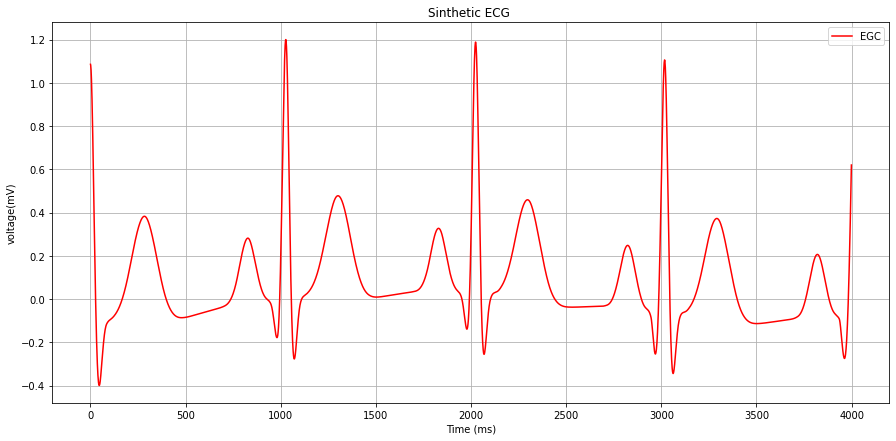

In [1]:
# -*- coding: utf-8 -*-
import math
import numpy as np
import scipy
import pandas as pd
import scipy.ndimage
import scipy.signal
import matplotlib.pyplot as plt

def signal_resample(
    signal, desired_length=None, sampling_rate=None, desired_sampling_rate=None
):
   
    if desired_length is None:
        desired_length = int(np.round(len(signal) * desired_sampling_rate / sampling_rate))

    # Sanity checks
    if len(signal) == desired_length:
        return signal

    resampled = _resample_interpolation(signal, desired_length)

    return resampled

def _resample_interpolation(signal, desired_length):
    resampled_signal = scipy.ndimage.zoom(signal, desired_length / len(signal))
    return resampled_signal

def _resample_sanitize(resampled_signal, desired_length):
    # Adjust extremities
    diff = len(resampled_signal) - desired_length
    if diff < 0:
        resampled_signal = np.concatenate([resampled_signal, np.full(np.abs(diff), resampled_signal[-1])])
    elif diff > 0:
        resampled_signal = resampled_signal[0:desired_length]
    return resampled_signal


def ecg_simulate(
    duration=10, length=None, sampling_rate=1000, noise=0.0, heart_rate=60, heart_rate_std=1, method="macsherry", random_state=None
):

    if length is None:
        length = duration * sampling_rate
    if duration is None:
        duration = length / sampling_rate
    
    approx_number_beats = int(np.round(duration * (heart_rate / 60)))
    ecg = _ecg_simulate_macsherry(
        sfecg=sampling_rate,
        N=approx_number_beats,
        Anoise=0,
        hrmean=heart_rate,
        hrstd=heart_rate_std,
        lfhfratio=0.5,
        sfint=sampling_rate,
        ti=(-70, -15, 0, 15, 100),
        ai=(1.2, -5, 30, -7.5, 0.75),
        bi=(0.25, 0.1, 0.1, 0.1, 0.4),
    )
    
    ecg = ecg[0:length]

    return ecg

def _ecg_simulate_rrprocess(
    flo=0.1, fhi=0.25, flostd=0.01, fhistd=0.01, lfhfratio=0.5, hrmean=60, hrstd=1, sfrr=1, n=256
):
    w1 = 2 * np.pi * flo
    w2 = 2 * np.pi * fhi
    c1 = 2 * np.pi * flostd
    c2 = 2 * np.pi * fhistd
    sig2 = 1
    sig1 = lfhfratio
    rrmean = 60 / hrmean
    rrstd = 60 * hrstd / (hrmean * hrmean)

    df = sfrr / n
    w = np.arange(n) * 2 * np.pi * df
    dw1 = w - w1
    dw2 = w - w2

    Hw1 = sig1 * np.exp(-0.5 * (dw1 / c1) ** 2) / np.sqrt(2 * np.pi * c1 ** 2)
    Hw2 = sig2 * np.exp(-0.5 * (dw2 / c2) ** 2) / np.sqrt(2 * np.pi * c2 ** 2)
    Hw = Hw1 + Hw2
    Hw0 = np.concatenate((Hw[0 : int(n / 2)], Hw[int(n / 2) - 1 :: -1]))
    Sw = (sfrr / 2) * np.sqrt(Hw0)

    ph0 = 2 * np.pi * np.random.uniform(size=int(n / 2 - 1))
    ph = np.concatenate([[0], ph0, [0], -np.flipud(ph0)])
    SwC = Sw * np.exp(1j * ph)
    x = (1 / n) * np.real(np.fft.ifft(SwC))

    xstd = np.std(x)
    ratio = rrstd / xstd
    return rrmean + x * ratio  # Return RR

def _ecg_simulate_macsherry(
    sfecg=256,
    N=256,
    Anoise=0,
    hrmean=60,
    hrstd=1,
    lfhfratio=0.5,
    sfint=512,
    ti=(-70, -15, 0, 15, 100),
    ai=(1.2, -5, 30, -7.5, 0.75),
    bi=(0.25, 0.1, 0.1, 0.1, 0.4),
):
    if not isinstance(ti, np.ndarray):
        ti = np.array(ti)
    if not isinstance(ai, np.ndarray):
        ai = np.array(ai)
    if not isinstance(bi, np.ndarray):
        bi = np.array(bi)

    ti = ti * np.pi / 180

    
    hrfact = np.sqrt(hrmean / 60)
    hrfact2 = np.sqrt(hrfact)
    bi = hrfact * bi
    ti = np.array([hrfact2, hrfact, 1, hrfact, hrfact2]) * ti

    
    q = np.round(sfint / sfecg)
    qd = sfint / sfecg

    
    flo = 0.1
    fhi = 0.25
    flostd = 0.01
    fhistd = 0.01

    
    sfrr = 1
    trr = 1 / sfrr
    rrmean = 60 / hrmean
    n = 2 ** (np.ceil(np.log2(N * rrmean / trr)))

    rr0 = _ecg_simulate_rrprocess(flo, fhi, flostd, fhistd, lfhfratio, hrmean, hrstd, sfrr, n)

    
    rr = signal_resample(rr0, sampling_rate=1, desired_sampling_rate=sfint)

    
    dt = 1 / sfint
    rrn = np.zeros(len(rr))
    tecg = 0
    i = 0
    while i < len(rr):
        tecg += rr[i]
        ip = int(np.round(tecg / dt))
        rrn[i:ip] = rr[i]
        i = ip
    Nt = ip

    
    x0 = np.array([1, 0, 0.04])

    
    Tspan = [0, (Nt - 1) * dt]
    t_eval = np.linspace(0, (Nt - 1) * dt, Nt)

    
    result = scipy.integrate.solve_ivp(
        lambda t, x: _ecg_simulate_derivsecgsyn(t, x, rrn, ti, sfint, ai, bi), Tspan, x0, t_eval=t_eval
    )
    X0 = result.y

    
    X = X0[:, np.arange(0, X0.shape[1], q).astype(int)]

    
    z = X[2, :].copy()
    zmin = np.min(z)
    zmax = np.max(z)
    zrange = zmax - zmin
    z = (z - zmin) * 1.6 / zrange - 0.4

    
    eta = 2 * np.random.uniform(len(z)) - 1
    return z + Anoise * eta  # Return signal


def _ecg_simulate_derivsecgsyn(t, x, rr, ti, sfint, ai, bi):

    ta = math.atan2(x[1], x[0])
    r0 = 1
    a0 = 1.0 - np.sqrt(x[0] ** 2 + x[1] ** 2) / r0

    ip = np.floor(t * sfint).astype(int)
    w0 = 2 * np.pi / rr[min(ip, len(rr) - 1)]
    

    fresp = 0.25
    zbase = 0.005 * np.sin(2 * np.pi * fresp * t)

    dx1dt = a0 * x[0] - w0 * x[1]
    dx2dt = a0 * x[1] + w0 * x[0]

    dti = (ta - ti) - np.round((ta - ti) / 2 / np.pi) * 2 * np.pi
    dx3dt = -np.sum(ai * dti * np.exp(-0.5 * (dti / bi) ** 2)) - 1 * (x[2] - zbase)

    dxdt = np.array([dx1dt, dx2dt, dx3dt])
    return dxdt

ecg_com = ecg_simulate(duration=4, length=None, sampling_rate=1000, heart_rate=60, method="macsherry")


print("*********************************************************************")
plt.rcParams['figure.figsize'] = [15, 7]
plt.plot(ecg_com, 'r', label="EGC" )
plt.title('Sinthetic ECG ')
plt.xlabel('Time (ms)')
plt.ylabel('voltage(mV)')
plt.legend(loc="upper right")
plt.grid()
plt.show()

